In [2]:
import subprocess
import os
import pandas as pd
import random
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score,precision_recall_curve
import numpy as np
from tqdm import tqdm
import argparse

#DIRPATH = os.path.dirname(os.path.realpath(__file__))
EXECDIR = "/cellar/users/snwright/Data/Network_Analysis/Edge_Prediction/kpisti-L3-ed6b18f/"
DATADIR = "/cellar/users/snwright/Data/Network_Analysis/Processed_Data/v2_2022/"
RESULTDIR = "/cellar/users/snwright/Data/Network_Analysis/Edge_Prediction/L3_outputs/"


In [83]:

def l3_edge_prediction(filepath, name, outpath, execdir):
    """_summary_

    Args:
        filepath (_type_): Current path to edge file
        name (_type_): name to append to output files
        outpath (_type_): Location to save the outputs
        execdir (_type_): Location of the L3.out executable
    """
    subprocess.call([DIRPATH+"/../L3_prediction.sh", filepath, name, outpath, execdir])

class EdgePredictor:
    def __init__(self, edgefile, net_name):
        self.edgefile = edgefile
        self.net_name = net_name
        self.edge_count = self.get_edge_count()
        self.node_count = self.get_node_count()
        
    def get_node_count(self):
        command = ['wc', '-l', self.edgefile.split("_net.txt")[0]+ ".nodelist"]
        result = subprocess.run(command, capture_output=True, text=True)
        output = int(result.stdout.strip().split()[0])
        return output - 1
        
    def get_edge_count(self):
        command = ['wc', '-l', self.edgefile]
        result = subprocess.run(command, capture_output=True, text=True)
        output = int(result.stdout.strip().split()[0])
        return output - 1
    
    def run_10_fold_cv(self, pred_method, nfolds=10):
        shuffled_idx = random.sample([i for i in range(self.edge_count)], self.edge_count)
        folds = [shuffled_idx[i::nfolds] for i in range(nfolds)]
        net_data = self.load_edge_list(self.edgefile)
        if pred_method == 'L3':
            prediction_files = []
            test_files = []
            for i in tqdm(range(nfolds)):
                net_data.loc[folds[i]].to_csv(self.edgefile+".fold"+str(i+1)+"_test", sep='\t', index=False)
                test_files.append(self.edgefile+".fold"+str(i+1)+"_test")
                net_data.drop(index=folds[i]).to_csv(self.edgefile+".fold"+str(i+1), sep='\t', index=False)
                l3_edge_prediction(self.edgefile+".fold"+str(i+1), self.net_name + "fold"+str(i+1), RESULTDIR, EXECDIR)
                prediction_files.append(RESULTDIR + "L3_predictions_" + self.net_name + "fold"+str(i+1) + ".dat")
                os.remove(self.edgefile+".fold"+str(i+1))
        return prediction_files, test_files
    
    def run_single_prediction(self, pred_method):
        if pred_method == 'L3':
            l3_edge_prediction(self.edgefile, self.net_name, RESULTDIR, EXECDIR)
            prediction_file = RESULTDIR + "L3_predictions_" + self.net_name + ".dat"
        else:
            raise NotImplementedError("Only L3 is currently implemented.")
        return prediction_file

    
class PredictionResults:
    def __init__(self, prediction_files, test_files, edgefiles, names=None):
        if type(prediction_files) == str:
            prediction_files = [prediction_files for _ in range(len(test_files))]
        elif type(test_files) == str:
            test_files = [test_files for _ in range(len(prediction_files))]
        if type(edgefiles) == str:
            edgefiles = [edgefiles for _ in range(len(prediction_files))]

        self.edgefiles = edgefiles
        self.prediction_files = prediction_files
        self.test_files = test_files
        assert len(self.prediction_files) == len(self.test_files), "There must be the same number of performance files as test files."
        if names is None:
            names = ["fold"+str(i) for i in range (len(prediction_files))]
        self.names = names
        self.results = None
        
    def get_node_count(self, edgefile):
        command = ['wc', '-l', edgefile.split("_net.txt")[0]+ ".nodelist"]
        result = subprocess.run(command, capture_output=True, text=True)
        output = int(result.stdout.strip().split()[0])
        return output - 1
        
    def get_edge_count(self, edgefile):
        command = ['wc', '-l', edgefile]
        result = subprocess.run(command, capture_output=True, text=True)
        output = int(result.stdout.strip().split()[0])
        return output - 1
        
    def evaluate_prediction_performance(self, metrics = ["AUROC", "AUPRC", "P@500", "NDCG", "Baseline_AUPRC"], check_overlap=False):
        results = {"test":self.names, **{metric:[] for metric in metrics}}
        metric_funcs = {"AUROC":self.calculate_AUROC, "AUPRC":self.calculate_AUPRC, "P@500":self.calculate_P500, 
                        "NDCG":self.calculate_NDCG, 'Baseline_AUPRC':self.calculate_baseline_AUPRC}
        for i in range(len(self.prediction_files)):
            predicted_edges = self.load_prediction_file(self.prediction_files[i])
            test_edges = self.load_test_file(self.test_files[i])
            edgefile = self.edgefiles[i]
            if check_overlap:
                test_edges = self.exclude_network_overlap(test_edges, predicted_edges, edgefile)
            for metric in metrics:
                if metric == "Baseline_AUPRC":
                    results[metric].append(metric_funcs[metric](test_edges, edgefile))
                else:
                    results[metric].append(metric_funcs[metric](test_edges, predicted_edges))
        self.results = pd.DataFrame(results)
        
    def exclude_network_overlap(self, test_edges, predicted_edges, edgefile):
        all_edges = self.load_edge_list(edgefile, edge_tuples=True)
        check_edges = all_edges - set(predicted_edges.iloc[:, [0,1]].itertuples(index=False, name=None))
        keep_test_edges = set(test_edges) - check_edges
        return keep_test_edges
                
    def load_prediction_file(self, filepath):
        df = pd.read_csv(filepath, header=None, names=['Entrez_A', 'Entrez_B', 'Score'], sep="\t")
        df[['Entrez_A', 'Entrez_B']] = np.sort(df[['Entrez_A', 'Entrez_B']].values, axis=1)  # Sort each edge
        return df
    
    def load_test_file(self, filepath):
        df = pd.read_csv(filepath, sep="\t", usecols=[0,1])
        df[['Entrez_A', 'Entrez_B']] = np.sort(df[['Entrez_A', 'Entrez_B']].values, axis=1)  # Sort each edge
        return set(df.itertuples(index=False, name=None))
    
    def load_edge_list(self, filepath, edge_tuples=False):
        df = pd.read_csv(filepath, sep="\t", usecols=[0,1])
        try:
            df[['Entrez_A', 'Entrez_B']] = np.sort(df[['Entrez_A', 'Entrez_B']].values, axis=1)
        except KeyError as e:
            print(self.edgefile)
            print(df.head())# Sort each edge
            raise e
        if edge_tuples:
            return set(df.iloc[:, [0,1]].itertuples(index=False, name=None))
        else:
            return df
        
    def calculate_baseline_AUPRC(self, test_edges, edgefile):
        node_count = self.get_node_count(edgefile)
        edge_count = self.get_edge_count(edgefile)
        positives = len(test_edges)
        # all possible predicted edges is equal to the pairwise combinations of nodes minus the number of edges in the network (without the held out set)
        all_possible = (node_count * (node_count - 1) / 2) - (edge_count - positives)
        return positives/all_possible
            
    def calculate_AUROC(self, test_edges, predicted_edges):
        y_true = [edge in test_edges for edge in predicted_edges[['Entrez_A', 'Entrez_B']].itertuples(index=False, name=None)]
        scores = predicted_edges['Score'].values
        auroc = roc_auc_score(y_true, scores)
        return auroc
    
    def calculate_AUPRC(sel, test_edges, predicted_edges):
        y_true = [edge in test_edges for edge in predicted_edges[['Entrez_A', 'Entrez_B']].itertuples(index=False, name=None)]
        scores = predicted_edges['Score'].values
        precision, recall, _ = precision_recall_curve(y_true, scores)
        return auc(recall, precision)
    
    def calculate_P500(self, test_edges, predicted_edges, k=500):
        top_k_preds = predicted_edges.nlargest(k, 'Score')[['Entrez_A', 'Entrez_B']].itertuples(index=False, name=None)
        relevant_at_k = len(set(top_k_preds) & test_edges)
        return relevant_at_k / k
    
    def calculate_NDCG(self, test_edges, predicted_edges):
        y_true = np.array([edge in test_edges for edge in predicted_edges[['Entrez_A', 'Entrez_B']].itertuples(index=False, name=None)])
        scores = predicted_edges['Score'].values
        return self.ndcg_at_k(y_true, scores)
    
    def ndcg_at_k(self, y_true, scores, k=None):
        actual = self.dcg_at_k(y_true, scores, k)
        best = self.dcg_at_k(y_true, y_true, k)
        return actual / best

    def dcg_at_k(self, y_true, scores, k=None):
        order = np.argsort(scores)[::-1]
        y_true = np.take(y_true, order[:k])
        gain = 2 ** y_true - 1
        discounts = np.log2(np.arange(len(y_true)) + 2)
        return np.sum(gain / discounts)
    
    def write_results(self, savepath):
        self.results.to_csv(savepath, sep="\t", index=False)
        
if False:#__name__=="__main__":
    parser = argparse.ArgumentParser(description='Run edge prediction on a network.')
    parser.add_argument("prefix_file", type=str, help='File containing prefixes')
    parser.add_argument("save_path", type=str, help="Full file path to save results")
    args = parser.parse_args()
    #prefs = [x.split("_L3_results.tsv")[0] for x in outputs]
    with open(args.prefix_file, 'r') as f:
        prefs = f.read().splitlines()
    results = []
    for pref in tqdm(prefs):
        pred_files = ["/cellar/users/snwright/Data/Network_Analysis/Edge_Prediction/L3_outputs/L3_predictions_" + pref +"fold" + str(i)+ ".dat" for i in range(1, 11)]
        test_files = ["/cellar/users/snwright/Data/Network_Analysis/Processed_Data/v2_2022/" + pref + "_net.txt.fold" + str(i)+ "_test" for i in range(1, 11)]
        edgefile = "/cellar/users/snwright/Data/Network_Analysis/Processed_Data/v2_2022/" + pref + "_net.txt"
        test = PredictionResults(pred_files, test_files, edgefile)
        test.evaluate_prediction_performance()
        df = test.results
        df['network'] = pref
        results.append(df)
    results = pd.concat(results)
    results.to_csv(args.save_path, sep="\t", index=False)


# if __name__ == "__main__":
#     # Run the edge prediction script
#     parser = argparse.ArgumentParser(description='Run edge prediction on a network.')
#     parser.add_argument("network_prefix", type=str, 
# 		help='Prefix of network to be evaluated. File must be 2-column edge list where each line is a gene interaction separated by a tab delimiter.')
#     args = parser.parse_args()
#     epr = EdgePredictor(DATADIR+ args.network_prefix+"_net.txt", args.network_prefix)
#     a, b = epr.run_10_fold_cv("L3", nfolds=10)
#     results = PredictionResults(a, b, DATADIR+ args.network_prefix+"_net.txt")
#     results.evaluate_prediction_performance()
#     results.results.to_csv("/cellar/users/snwright/Data/Network_Analysis/Edge_Prediction/" +args.network_prefix + "_L3_results.tsv", sep="\t", index=False)

In [20]:
outputs=["bioplex.v3.293T_L3_results.tsv","havugimana_L3_results.tsv","pips_L3_results.tsv",
"bioplex.v3.HCT116_L3_results.tsv", "hi.union_L3_results.tsv", "reactome.v83_L3_results.tsv",
"dip.PC_L3_results.tsv", "pid.12_L3_results.tsv","wan_L3_results.tsv", "bind.v8_L3_results.tsv", 
"multinet_L3_results.tsv", "signor_L3_results.tsv"]

In [84]:
pref = prefs[0]
pred_files = ["/cellar/users/snwright/Data/Network_Analysis/Edge_Prediction/L3_outputs/L3_predictions_" + pref +"fold" + str(i)+ ".dat" for i in range(1, 11)]
test_files = ["/cellar/users/snwright/Data/Network_Analysis/Processed_Data/v2_2022/humannet.v3.gsp_net.txt" for _ in range(len(pred_files))]
edgefile = "/cellar/users/snwright/Data/Network_Analysis/Processed_Data/v2_2022/" + pref + "_net.txt"
test = PredictionResults(pred_files, test_files, edgefile)

In [78]:
test.evaluate_prediction_performance()
a = test.results

In [85]:
test.evaluate_prediction_performance(check_overlap=True)
b = test.results

In [86]:
a

,test,AUROC,AUPRC,P@500,NDCG,Baseline_AUPRC
0,fold0,0.556281,0.009679,0.030,0.605515,0.025313
1,fold1,0.577167,0.010532,0.042,0.610523,0.025313
2,fold2,0.567611,0.010191,0.034,0.608258,0.025313
3,fold3,0.569927,0.010153,0.026,0.607399,0.025313
4,fold4,0.569468,0.010472,0.036,0.609064,0.025313
5,fold5,0.556213,0.009790,0.032,0.605844,0.025313
6,fold6,0.569624,0.010015,0.026,0.608793,0.025313
7,fold7,0.578944,0.010115,0.024,0.607966,0.025313
8,fold8,0.557616,0.009636,0.028,0.606417,0.025313
9,fold9,0.568563,0.009993,0.036,0.608107,0.025313


In [87]:
b

,test,AUROC,AUPRC,P@500,NDCG,Baseline_AUPRC
0,fold0,0.556281,0.009679,0.030,0.605515,0.025268
1,fold1,0.577167,0.010532,0.042,0.610523,0.025267
2,fold2,0.567611,0.010191,0.034,0.608258,0.025267
3,fold3,0.569927,0.010153,0.026,0.607399,0.025267
4,fold4,0.569468,0.010472,0.036,0.609064,0.025267
5,fold5,0.556213,0.009790,0.032,0.605844,0.025266
6,fold6,0.569624,0.010015,0.026,0.608793,0.025266
7,fold7,0.578944,0.010115,0.024,0.607966,0.025267
8,fold8,0.557616,0.009636,0.028,0.606417,0.025266
9,fold9,0.568563,0.009993,0.036,0.608107,0.025265


In [72]:
#prefs = [x.split("_L3_results.tsv")[0] for x in outputs]
prefs = ['hein', 'innatedb_all', 'matrixdb', 'reactomeFI.21']
results = []
for pref in tqdm(prefs):
    pred_files = ["/cellar/users/snwright/Data/Network_Analysis/Edge_Prediction/L3_outputs/L3_predictions_" + pref +"fold" + str(i)+ ".dat" for i in range(1, 11)]
    test_files = ["/cellar/users/snwright/Data/Network_Analysis/Processed_Data/v2_2022/" + pref + "_net.txt.fold" + str(i)+ "_test" for i in range(1, 11)]
    edgefile = "/cellar/users/snwright/Data/Network_Analysis/Processed_Data/v2_2022/" + pref + "_net.txt"
    test = PredictionResults(pred_files, test_files, edgefile)
    test.evaluate_prediction_performance()
    results.append(test.results)
    

 25%|██▌       | 1/4 [00:15<00:46, 15.39s/it]


KeyboardInterrupt: 

In [25]:
# results = []
# for output in outputs:
#     df = pd.read_csv("/cellar/users/snwright/Data/Network_Analysis/Edge_Prediction/" + output, sep="\t", index_col=None)
#     df['network'] = output.split("_")[0]
#     results.append(df)

In [43]:
x = set([1,2,3,4,5,6,7])
y = set([1,2,3,4])

In [44]:
x-y

{5, 6, 7}

In [59]:
for i, df in enumerate(results):
    df['network']  = prefs[i]

In [60]:
results_df = pd.concat(results)

In [61]:
results_df.head()

,test,AUROC,AUPRC,P@500,NDCG,Baseline_AUPRC,network
0,fold0,0.865521,0.037576,0.130,0.591971,0.000151,hein
1,fold1,0.874100,0.060087,0.194,0.623276,0.000151,hein
2,fold2,0.875641,0.049388,0.164,0.605854,0.000151,hein
3,fold3,0.847454,0.047785,0.158,0.599591,0.000151,hein
4,fold4,0.861934,0.048800,0.144,0.606868,0.000151,hein


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

In [63]:
results_df = pd.concat([results_df, keep_results])

In [55]:
keep_results = results_df.copy()

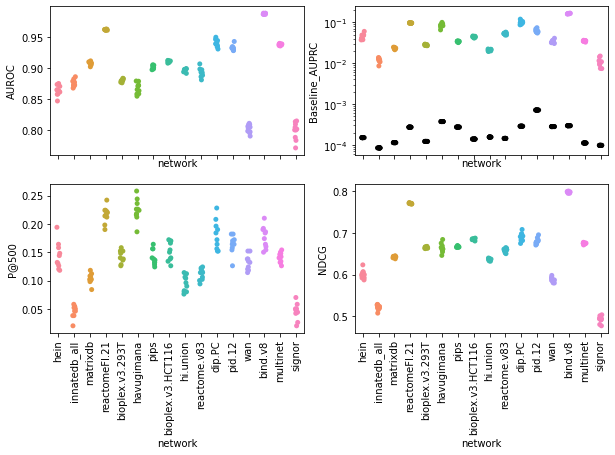

In [64]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(10,6))
sns.stripplot(data = results_df, x='network', y='AUROC', ax=ax1)
sns.stripplot(data = results_df, x='network', y='AUPRC', ax=ax2)
sns.stripplot(data=results_df, x='network', y='Baseline_AUPRC', ax=ax2, color="black")
sns.stripplot(data = results_df, x='network', y='P@500', ax=ax3)
sns.stripplot(data = results_df, x='network', y='NDCG', ax=ax4)
ax3.tick_params(axis='x', rotation=90)
ax4.tick_params(axis='x', rotation=90)
ax2.set_yscale("log")

<AxesSubplot:xlabel='network', ylabel='P@500'>

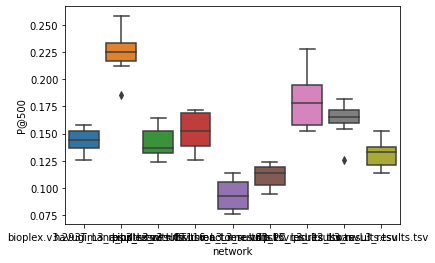

In [11]:
sns.boxplot(data = results_df, x='network', y='P@500')